In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import yfinance as yf
import alphalens as al

from prices import read_stock_prices
from plotter import plot_sentiments, plot_correlations

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#stocks = ["PLTR", "TSLA", "AMC", "NOK", "GME", "AAPL"]
stocks = ["AAPL", "PLTR", "TSLA", "NOK"]
#stocks = ["AAPL", "PLTR", "TSLA"]
#stocks = ["FB", "AAPL", "AMZN", "GOOG", "NFLX", "PLTR", "TSLA"]
factors = ["Vader Twitter", "Roberta Twitter", "Roberta Reddit"]

## Sentiments Data

### Vader Twitter

In [3]:
vader_df = pd.concat([pd.read_csv('sentiments/stocks_vader_mean_sentiment.csv', parse_dates=['Date']), 
                     pd.read_csv('sentiments/memestocks_vader_mean_sentiment.csv', parse_dates=['Date'])])
vader_df["Factor"] = "Vader Twitter"

### Roberta Twitter

In [4]:
roberta_twitter = pd.concat([pd.read_csv("sentiments/roberta-sentiment2.csv", index_col=0, parse_dates=['Date']), 
                        pd.read_csv("sentiments/roberta-sentiment-meme.csv", index_col=0, parse_dates=['Date']),
                        pd.read_csv("sentiments/roberta-sentiment-fang.csv", index_col=0, parse_dates=['Date'])])
roberta_twitter["Factor"] = "Roberta Twitter"

### Roberta Reddit

In [5]:
roberta_reddit = pd.read_csv("sentiments/reddit-roberta-sentiment.csv", index_col=0, parse_dates=['Date'])
roberta_reddit["Factor"] = "Roberta Reddit"

In [6]:
roberta_reddit.Stock.unique()

array(['AMC', 'GME', 'NOK', 'PLTR', 'TSLA'], dtype=object)

In [7]:
sentiments_df = pd.concat([vader_df, roberta_twitter, roberta_reddit])
sentiments_df["Date"] = sentiments_df["Date"] + datetime.timedelta(days=1)
sentiments_df

,Date,Stock,Sentiment,Factor
0,2021-01-02,AAPL,0.212245,Vader Twitter
1,2021-01-02,PLTR,0.230110,Vader Twitter
2,2021-01-02,TSLA,0.206411,Vader Twitter
3,2021-01-03,AAPL,0.180537,Vader Twitter
4,2021-01-03,PLTR,0.153601,Vader Twitter
...,...,...,...,...
497,2021-04-27,TSLA,-0.505738,Roberta Reddit
498,2021-04-28,TSLA,-0.544543,Roberta Reddit
499,2021-04-29,TSLA,-0.227481,Roberta Reddit
500,2021-04-30,TSLA,-0.034962,Roberta Reddit


## Prices

In [8]:

price_data = read_stock_prices(stocks, "Open")

In [9]:
sentiments_prices = pd.merge(sentiments_df, price_data,  how='left', on = ['Date','Stock'])
sentiments_prices.dropna(inplace = True)
sentiments_prices

,Date,Stock,Sentiment,Factor,Price
6,2021-01-04,AAPL,0.186930,Vader Twitter,133.094712
7,2021-01-04,PLTR,0.196581,Vader Twitter,23.910000
8,2021-01-04,TSLA,0.154241,Vader Twitter,719.460022
9,2021-01-05,AAPL,0.144920,Vader Twitter,128.479455
10,2021-01-05,PLTR,0.151369,Vader Twitter,23.180000
...,...,...,...,...,...
2416,2021-04-26,TSLA,-0.451026,Roberta Reddit,741.000000
2417,2021-04-27,TSLA,-0.505738,Roberta Reddit,717.960022
2418,2021-04-28,TSLA,-0.544543,Roberta Reddit,696.409973
2419,2021-04-29,TSLA,-0.227481,Roberta Reddit,699.510010


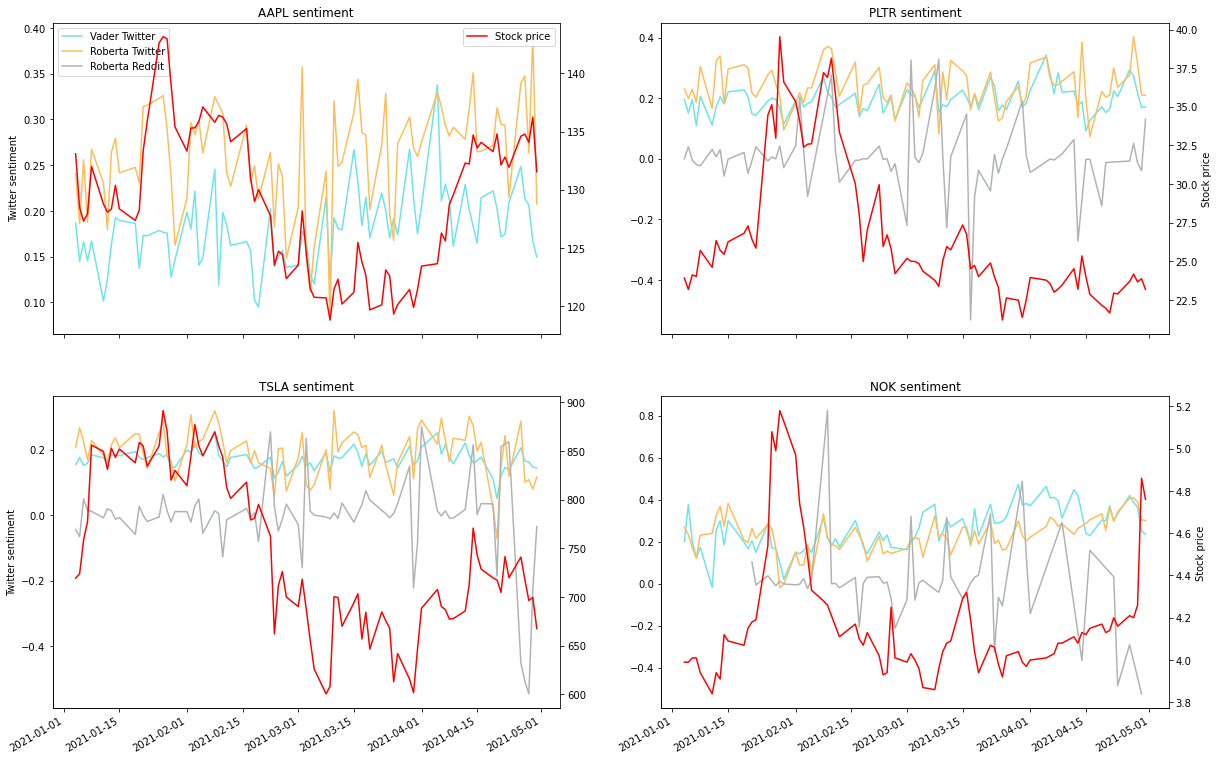

In [10]:
plot_sentiments(sentiments_prices, stocks, factors)

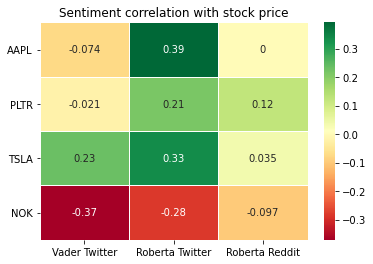

In [11]:
plot_correlations(sentiments_prices, stocks, factors)

## Alphalens

In [12]:
factor_data = {}

prices = price_data.pivot(index='Date', columns='Stock', values='Price')

for factor in factors: 
    factor_df = sentiments_prices[sentiments_prices['Factor'] == factor]
    factor_df = factor_df.pivot(index='Date', columns='Stock', values='Sentiment')
    data = al.utils.get_clean_factor_and_forward_returns(factor_df.stack(), prices, quantiles=5, bins=None, periods=[1])
    factor_data[factor] = data
    
factor_data[factors[0]].head()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.9% entries from factor data: 0.0% in forward returns computation and 2.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D    factor  factor_quantile
date       asset                                     
2021-01-04 AAPL  -0.034676  0.186930                2
           NOK    0.000000  0.201067                5
           PLTR  -0.030531  0.196581                4
           TSLA   0.005838  0.154241                1
2021-01-05 AAPL  -0.009078  0.144920                1

### Alphalens Format with Unix Time
Alphalen's `factor_rank_autocorrelation` and `mean_return_by_quantile` functions require unix timestamps to work, so we'll also create factor dataframes with unix time.

In [13]:
unix_factor_data = {
    factor: data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in data.index.values],
        names=['date', 'asset']))
    for factor, data in factor_data.items()}

### Factor Returns
Let's view the factor returns over time. We should be seeing it generally move up and to the right.

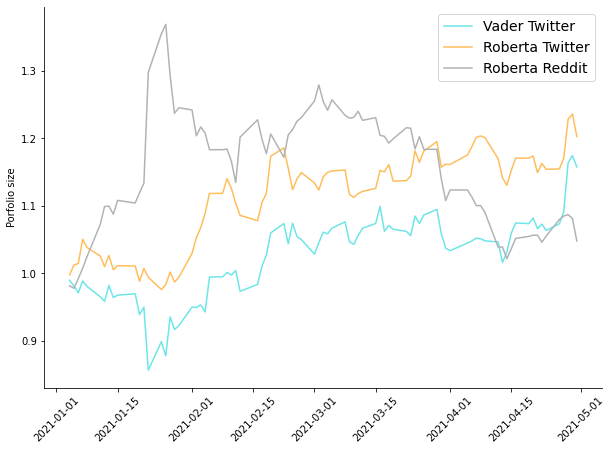

In [14]:
ls_factor_returns = pd.DataFrame()

for factor_name, data in factor_data.items():
    ls_factor_returns[factor_name] = al.performance.factor_returns(data).iloc[:, 0]

cum_returns = (1 + ls_factor_returns).cumprod().ffill()

fig = plt.figure(figsize=(10, 7), facecolor='white')
ax = plt.axes(frameon=True)
ax.set_prop_cycle('color', ['#6ce5e8', '#ffbd59', '#b1b3b3'])
#plt.axis('off')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(rotation=45)

plt.rcParams.update({'font.size': 14})
plt.plot(cum_returns)
plt.legend(["Vader Twitter", "Roberta Twitter", "Roberta Reddit"])
plt.ylabel("Porfolio size")
plt.savefig("poster1.png");

### Basis Points Per Day per Quantile
It is not enough to look just at the factor weighted return. A good alpha is also monotonic in quantiles. Let's looks the basis points for the factor returns.

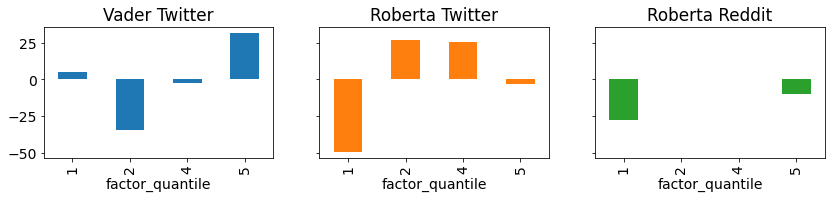

In [15]:
qr_factor_returns = pd.DataFrame()

for factor_name, data in unix_factor_data.items():
    qr_factor_returns[factor_name] = al.performance.mean_return_by_quantile(data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(5,3),
    figsize=(14, 14),
    legend=False);

### Turnover Analysis
Without doing a full and formal backtest, we can analyze how stable the alphas are over time. Stability in this sense means that from period to period, the alpha ranks do not change much. Since trading is costly, we always prefer, all other things being equal, that the ranks do not change significantly per period. We can measure this with the **Factor Rank Autocorrelation (FRA)**.

<AxesSubplot:title={'center':'Factor Rank Autocorrelation'}, xlabel='date'>

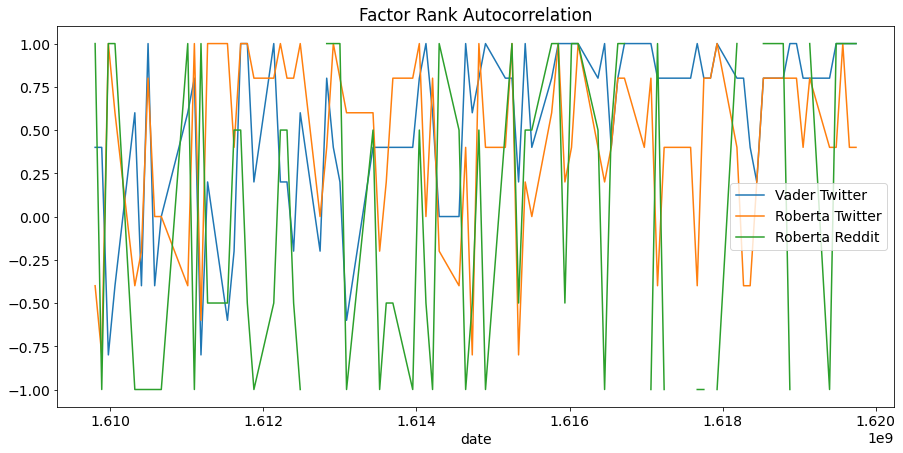

In [16]:
ls_FRA = pd.DataFrame()

for factor, data in unix_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(data)

ls_FRA.plot(title="Factor Rank Autocorrelation", figsize=(15, 7))

### Sharpe Ratio of the Alphas
The last analysis we'll do on the factors will be sharpe ratio. Let's see what the sharpe ratio for the factors are. Generally, a Sharpe Ratio of near 1.0 or higher is an acceptable single alpha for this universe.

In [17]:
daily_annualization_factor = np.sqrt(252)

(daily_annualization_factor * ls_factor_returns.mean() / ls_factor_returns.std()).round(2)

Vader Twitter      1.41
Roberta Twitter    2.16
Roberta Reddit     0.57
dtype: float64